# 

In [2]:
import logging, os
logging.disable(logging.WARNING)
logging.disable(logging.INFO)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, \
    RandomFlip, RandomRotation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import utils
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH  = 160

#Para aceder às paths indicadas abaixo é so substituir pela sua path correspondente às pastas de treino, validação e teste.

TRAIN_PATH      = "cats_and_dogs\\train"
VALIDATION_PATH = "cats_and_dogs\\validation" 
TEST_PATH       = "cats_and_dogs\\test"

TEST_SAMPLES = 500 

NUM_CLASSES = 2

# Building the datasets needed
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    labels     = 'inferred',
    label_mode = 'categorical',
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_PATH,
    labels     = 'inferred',
    label_mode = 'categorical',
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

labels = test_ds.class_names

train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

print(labels)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
['cats', 'dogs']


In [4]:
vgg16_model = VGG16(weights='imagenet', include_top=False, classes=2)
vgg16_model.trainable = False


In [5]:
resNet50_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')


# RestNet50

In [7]:
# Create the CNN model

model = tf.keras.models.Sequential()

model.add(resNet50_model)

model.add(Dense(NUM_CLASSES, activation="softmax"))
model.layers[0].trainable = False

# Model loss function and Adam optimizer with learning rate of 0.001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
EPOCHS  = 10
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/10
63/63 [==============================] - 59s 908ms/step - loss: 0.2074 - accuracy: 0.9110 - val_loss: 0.1520 - val_accuracy: 0.9400
Epoch 2/10
63/63 [==============================] - 54s 867ms/step - loss: 0.0847 - accuracy: 0.9655 - val_loss: 0.1551 - val_accuracy: 0.9420
Epoch 3/10
63/63 [==============================] - 51s 804ms/step - loss: 0.0590 - accuracy: 0.9765 - val_loss: 0.1441 - val_accuracy: 0.9460
Epoch 4/10
63/63 [==============================] - 56s 885ms/step - loss: 0.0432 - accuracy: 0.9870 - val_loss: 0.1423 - val_accuracy: 0.9440
Epoch 5/10
63/63 [==============================] - 58s 930ms/step - loss: 0.0330 - accuracy: 0.9940 - val_loss: 0.1438 - val_accuracy: 0.9480
Epoch 6/10
63/63 [==============================] - 55s 870ms/step - loss: 0.0258 - accuracy: 0.9965 - val_loss: 0.1435 - val_accuracy: 0.9480
Epoch 7/10
63/63 [==============================] - 60s 954ms/step - loss: 0.0206 - accuracy: 0.9985 - val_loss: 0.1426 - val_accuracy: 0.9520

### Resultados

16/16 [==============================] - 11s 719ms/step


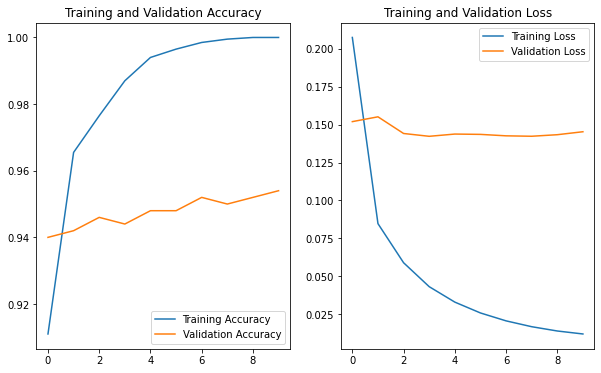

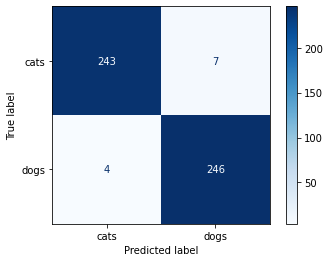

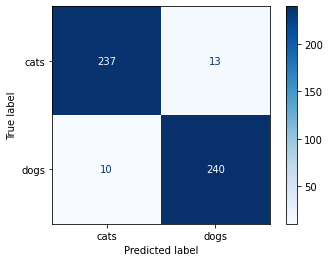


Falhou 11 de 500 exemplos de Teste
Taxa de acertos do conjunto de teste: 97.80%


In [9]:
y_pred = model.predict(test_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat([y for x, y in test_ds], axis=0)
y_true = tf.argmax(y_true, axis=1)

y_pred1 = model.predict(val_ds)
y_pred1 = tf.argmax(y_pred1, axis=1)

y_true1 = tf.concat([y for x, y in val_ds], axis=0)
y_true1 = tf.argmax(y_true1, axis=1)

# gerar graficos e matriz de confusao
cm = confusion_matrix(y_true, y_pred)
cm1 = confusion_matrix(y_true1, y_pred1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# calcular acertos no conjunto de teste
misses = np.count_nonzero(y_true-y_pred)
accuracy = (TEST_SAMPLES - misses) / TEST_SAMPLES

print(f"\nFalhou {misses} de {TEST_SAMPLES} exemplos de Teste")
print(f"Taxa de acertos do conjunto de teste: {(accuracy*100):.2f}%")

# VGG16

In [43]:
# Create the CNN model
model = tf.keras.models.Sequential([
    layers.Rescaling(2. / 255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),

    vgg16_model,
    
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.25),

    layers.Dense(NUM_CLASSES, activation="softmax")
])

# Model loss function and Adam optimizer with learning rate of 0.001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 160, 160, 3)       0         
                                                                 
 random_flip_13 (RandomFlip)  (None, 160, 160, 3)      0         
                                                                 
 random_rotation_13 (RandomR  (None, 160, 160, 3)      0         
 otation)                                                        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dense_26 (Dense)            (None, 32)                409632    
                                                     

In [44]:
EPOCHS  = 10
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/10
63/63 [==============================] - 107s 2s/step - loss: 0.5234 - accuracy: 0.7575 - val_loss: 0.2008 - val_accuracy: 0.9220
Epoch 2/10
63/63 [==============================] - 103s 2s/step - loss: 0.2720 - accuracy: 0.8840 - val_loss: 0.1762 - val_accuracy: 0.9260
Epoch 3/10
63/63 [==============================] - 103s 2s/step - loss: 0.2159 - accuracy: 0.9080 - val_loss: 0.1971 - val_accuracy: 0.9160
Epoch 4/10
63/63 [==============================] - 107s 2s/step - loss: 0.2029 - accuracy: 0.9140 - val_loss: 0.1822 - val_accuracy: 0.9340
Epoch 5/10
63/63 [==============================] - 116s 2s/step - loss: 0.1818 - accuracy: 0.9160 - val_loss: 0.1829 - val_accuracy: 0.9180
Epoch 6/10
63/63 [==============================] - 112s 2s/step - loss: 0.1442 - accuracy: 0.9395 - val_loss: 0.2092 - val_accuracy: 0.9240
Epoch 7/10
63/63 [==============================] - 104s 2s/step - loss: 0.1803 - accuracy: 0.9180 - val_loss: 0.1747 - val_accuracy: 0.9200
Epoch 8/10
63

### Resultados

16/16 [==============================] - 20s 1s/step


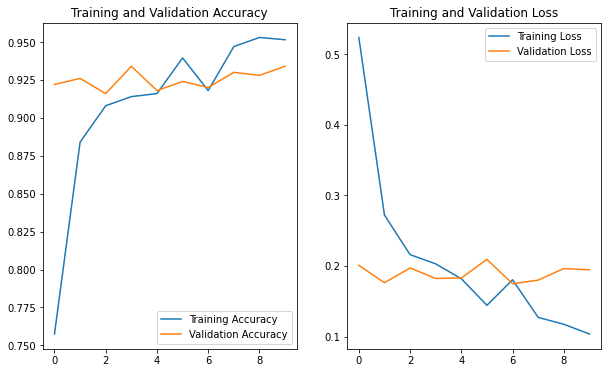

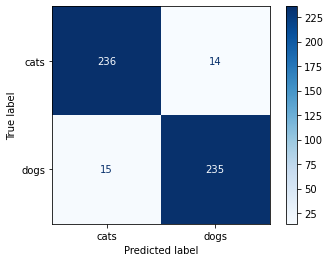

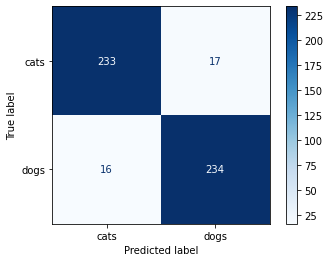


Falhou 29 de 500 exemplos de Teste
Taxa de acertos do conjunto de teste: 94.20%


In [45]:
y_pred = model.predict(test_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat([y for x, y in test_ds], axis=0)
y_true = tf.argmax(y_true, axis=1)

y_pred1 = model.predict(val_ds)
y_pred1 = tf.argmax(y_pred1, axis=1)

y_true1 = tf.concat([y for x, y in val_ds], axis=0)
y_true1 = tf.argmax(y_true1, axis=1)

# gerar graficos e matriz de confusao
cm = confusion_matrix(y_true, y_pred)
cm1 = confusion_matrix(y_true1, y_pred1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# calcular acertos no conjunto de teste
misses = np.count_nonzero(y_true-y_pred)
accuracy = (TEST_SAMPLES - misses) / TEST_SAMPLES

print(f"\nFalhou {misses} de {TEST_SAMPLES} exemplos de Teste")
print(f"Taxa de acertos do conjunto de teste: {(accuracy*100):.2f}%")

# Resultados Desafio 4

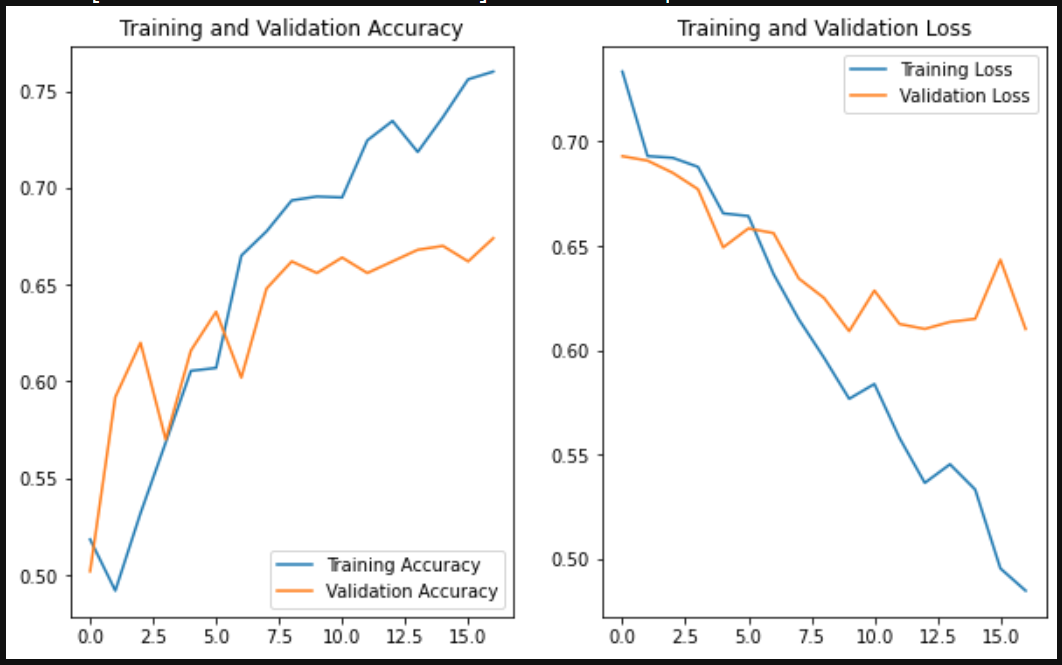

- Test_ds

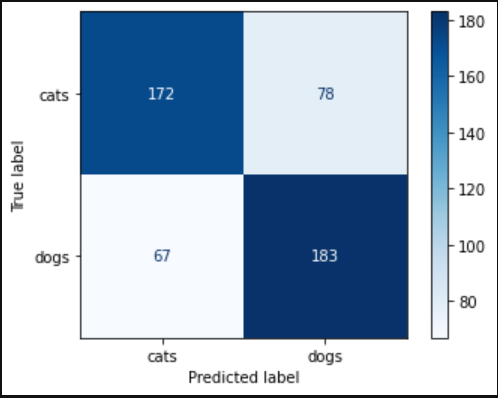

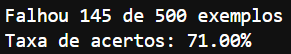

- Val_ds

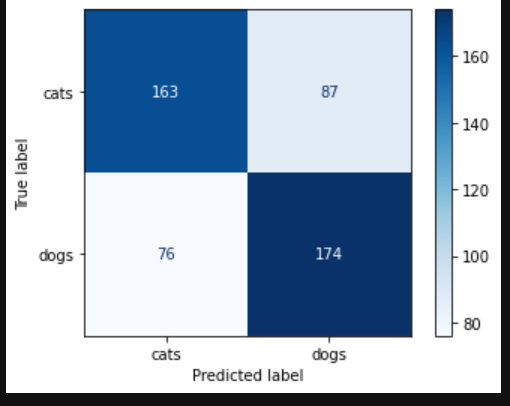